# Training a classifier to recognise hate speech on Twitter

In [1]:
import os
import nltk
print('The nltk version is {}.'.format(nltk.__version__))
#from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd

import re
import string

import numpy as np

import matplotlib

The nltk version is 3.3.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mednche\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#os.chdir("/Users/natachachenevoy/Documents/Twitter Analysis/Classifier")
os.chdir("C:/Users/mednche/Desktop/Hate-speech-twitter-NLP/")
os.getcwd()

'C:\\Users\\mednche\\Desktop\\Hate-speech-twitter-NLP'

## Import labeled Twitter datasets

In [15]:
data = pd.read_csv('TrainingTweets.csv', encoding='ISO-8859-1')

In [16]:
data.shape

(310, 2)

In [17]:
data.tail()

,tweet,class
305,well yes i mean you started off saying third l...,0
306,so my neighbours complained about my shed in t...,1
307,fucking fascist fucking liberal fucking racist...,1
308,fucking annoying when meat dairy and eggs are ...,0
309,i hate people i was wrong when i said 97.5 of ...,1


Note: you can see that each tweet has already been manually labeled 

##   Ensure balance in dataset

####   Turn data into lists

In [23]:
from sklearn.utils import shuffle

pos_tweets = data[data["class"] == 1]
pos_tweets = shuffle(pos_tweets)
print("{} hateful tweets".format(len(pos_tweets)))

neg_tweets = data[data["class"] == 0]
neg_tweets = shuffle(neg_tweets)
print("{} non hateful tweets".format(len(neg_tweets)))

101 hateful tweets
209 non hateful tweets


In [24]:
pos_tweets.head()

,tweet,class
296,why cheat fucking stupid ass prick,1
48,"saw some graffiti on the train today, it said ...",1
45,"Had enough of the fucking pakis man, time to l...",1
306,so my neighbours complained about my shed in t...,1
286,"""go burn in hell bitch""",1


In [25]:
neg_tweets.head()

,tweet,class
89,'RT @LazaroDaniella: if you love someone_ tell...,0
134,'@bxrnheater she nods_ confirming what the boy...,0
110,'Fucking league of memes. Is hilarious',0
225,i was aiming that message at the wafc fans tha...,0
186,referee tonight at the winter gardens blackpoo...,0


####  Select as many hateful as non-hateful tweets for an equal dataset

In [26]:
num = min(len(pos_tweets), len(neg_tweets))
data_balanced = pos_tweets[0:num].append(neg_tweets[0:num], ignore_index=True)

print('Number of tweets in balanced dataset: {}'.format(len(data_balanced)))

Number of tweets in balanced dataset: 202


In [27]:
data_balanced.head()

,tweet,class
0,why cheat fucking stupid ass prick,1
1,"saw some graffiti on the train today, it said ...",1
2,"Had enough of the fucking pakis man, time to l...",1
3,so my neighbours complained about my shed in t...,1
4,"""go burn in hell bitch""",1


## Part I. Preprocessing

### Clean tweets

In [28]:
def cleanTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to ''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # removing the RT before the @user 
    tweet = re.sub('rt','',tweet) 
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Convert @username to ''
    tweet = re.sub('@[^\s]+','',tweet) 
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # remove non ASCII characters (emojies)
    tweet= re.sub(r'[^\x00-\x7F]+','', tweet)
    # remove punctuation 
    tweet = "".join(l for l in tweet if l not in string.punctuation)
    #trim
    tweet = tweet.strip('\'"')
    # remove beginning and end space
    tweet = tweet.strip()
    
    return tweet

In [32]:
#  apply processing function
data_balanced['tweet'] = data_balanced['tweet'].apply(cleanTweet) 

In [33]:
data_balanced.tail()

,tweet,class
197,retweeted gazete krtk baskn oran akp de fethu...,0
198,probably gonna recolorshade this head crep,0
199,maniq gel polish on natural nails in champagne...,0
200,live on webcam,0
201,crazy car crash compilation pa 321,0


### Delete empty tweets

In [34]:
# replace the text of emtpy tweets '' by NA and then delete the row
data_balanced['tweet'].replace('', np.nan, inplace=True)
data_balanced.dropna(subset=['tweet'], inplace=True)

In [35]:
data_balanced.shape

(202, 2)

Note: How many empty tweets were removed in the process?

###  Tokenise

At the moment, the text of each tweet is a string. We would like to separate each word in that string. In NLP, this is called 'tokenising'.

When tokenising, each tweet (intially a string of text) is chopped into a list of tokens. 

A token is a word or a combination of 2 (bigram) or 3 (trigram) words such as ('back', 'off)' or ('send', 'them', home'). In this example, the ngrams only have a hateful meaning when considered as a group but they are not hateful when taken individually. 

In [41]:
data_tokenised = data_balanced.copy()

data_tokenised['tweet'] = data_tokenised['tweet'].apply(nltk.word_tokenize)

data_tokenised.head()

,tweet,class
0,"[why, cheat, fucking, stupid, ass, prick]",1
1,"[saw, some, graffiti, on, the, train, today, i...",1
2,"[had, enough, of, the, fucking, pakis, man, ti...",1
3,"[so, my, neighbours, complained, about, my, sh...",1
4,"[go, burn, in, hell, bitch]",1


Note: you can see that there are many words in the tweets that don't bring any meaning such as 'it', 'i' etc. These are called stopwords and need to be removed so that the classifier can focus on words that matter when telling the difference between hate and non-hate.

### Remove stopwords

####  Import English stopwords

In [42]:
stops = set(stopwords.words('english'))
#remove some words from the list:
item_to_delete = ['you', 'out', 'off', 'them', 'themselves', 'yourself', 'from', 'same']
stopWords = [e for e in stops if e not in item_to_delete]
item_to_add = ["youre", "r", "you're", "us", "doesnt", "im", "hes", "u", "ya", "ww", "dont", "https", "aint", "theres", "shouldnt", "thats", "amp", "wudnt", "gonna", "ur", "cant"]
for e in item_to_add:
    stopWords.append(e)

stopWords

['the',
 "that'll",
 'needn',
 'if',
 'then',
 'yourselves',
 'a',
 "shouldn't",
 'hers',
 "aren't",
 'it',
 'very',
 'own',
 'what',
 'am',
 'or',
 'being',
 "didn't",
 "couldn't",
 'while',
 'o',
 "needn't",
 'about',
 'other',
 'shan',
 "won't",
 "hasn't",
 'won',
 'with',
 'don',
 'ma',
 'me',
 'too',
 'has',
 'under',
 'd',
 'ours',
 'hasn',
 'yours',
 'i',
 'to',
 "you're",
 "should've",
 'no',
 'how',
 'did',
 "you'll",
 "hadn't",
 'until',
 'herself',
 'theirs',
 'more',
 't',
 's',
 'shouldn',
 "shan't",
 'hadn',
 'only',
 'most',
 'on',
 'not',
 'at',
 'between',
 'through',
 'll',
 "weren't",
 'this',
 'each',
 'she',
 'whom',
 'for',
 'we',
 'm',
 'down',
 'are',
 'up',
 'there',
 'haven',
 "she's",
 'below',
 'just',
 'its',
 'any',
 'ain',
 'but',
 'some',
 'be',
 "don't",
 "you've",
 'here',
 'before',
 'after',
 'as',
 "mightn't",
 'itself',
 'didn',
 'mightn',
 'should',
 'their',
 'against',
 'aren',
 'wasn',
 'further',
 'above',
 'will',
 'him',
 'isn',
 "mustn't",


In [45]:
data_tokenised_stpwd = data_tokenised.copy()

data_tokenised_stpwd['tweet'] = data_tokenised_stpwd['tweet'].apply(lambda x: [item for item in x if item not in stopWords])

data_tokenised_stpwd.head()

,tweet,class
0,"[cheat, fucking, stupid, ass, prick]",1
1,"[saw, graffiti, train, today, said, fuck, off,...",1
2,"[enough, fucking, pakis, man, time, leave, eur...",1
3,"[neighbours, complained, shed, front, garden, ...",1
4,"[go, burn, hell, bitch]",1


### Stemming

Plural to singular, verb root, word stem

In [89]:
pre_processed_data = data_tokenised_stpwd.copy()

#from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 
#lemma = WordNetLemmatizer()

ps = PorterStemmer() 

pre_processed_data['tweet'] = pre_processed_data['tweet'].apply(lambda x: [ps.stem(word) for word in x])
pre_processed_data['tweet'].head()

0                    [cheat, fuck, stupid, ass, prick]
1    [saw, graffiti, train, today, said, fuck, off,...
2         [enough, fuck, paki, man, time, leav, europ]
3    [neighbour, complain, shed, front, garden, who...
4                              [go, burn, hell, bitch]
Name: tweet, dtype: object

End of pre-processing step

Note: At this point, we have a dataset that has been cleaned and tokenised.

At this stage the classfier won't be able to know which key words are responsible for a tweet being labelled 'hateful'. Is it because of the word 'everywhere' or the word 'fuck'?

To be able to learn what counts as hateful and what doesn't, the classifier also needs to know the 'hateful value' of each word (or combination of word) in a tweet.


Text themselves cannot be used by machine learning models. They expect their input to be numeric. So we need some way that can transform input text into numeric feature in a meaningful way. There are several approaches for this and we’ll briefly go through some of them.

In Part 2., we'll see how to convert the words into features so that we can feed it to a classifier for training or inference.

____________________________________________________________

## Part 2. Prepare the data to train the classifier

### Vocabulary of features

To classify the text into any category, we need to define some criteria. On the basis of those criteria, our classifier will learn that a particular kind of text falls in a particular category. This kind of criteria is known as feature. We can define one or more feature to train our classifier.

A simple way we can convert text to numeric feature is via binary encoding. In this scheme, we create a vocabulary by looking at each distinct word in the whole dataset (corpus). For each document, the output of this scheme will be a vector of size N where N is the total number of words in our vocabulary. Initially all entries in the vector will be 0. If the word in the given document exists in the vocabulary then vector element at that position is set to 1. Let’s implement this to understand.

Let's create a vocabulary: a set of unique words in the dataset

In [90]:
vocab = [word for tweet in pre_processed_data['tweet'] for word in tweet]
print('Vocabulary size: {}'.format(len(vocab)))

Vocabulary size: 1287


In [91]:
vocab

['cheat',
 'fuck',
 'stupid',
 'ass',
 'prick',
 'saw',
 'graffiti',
 'train',
 'today',
 'said',
 'fuck',
 'off',
 'home',
 'you',
 'black',
 'slagfound',
 'pretti',
 'funni',
 'enough',
 'fuck',
 'paki',
 'man',
 'time',
 'leav',
 'europ',
 'neighbour',
 'complain',
 'shed',
 'front',
 'garden',
 'who',
 'neighbour',
 'church',
 'england',
 'bunch',
 'god',
 'bother',
 'cunt',
 'go',
 'burn',
 'hell',
 'bitch',
 'fuck',
 'dyke',
 'fuck',
 'paki',
 'come',
 'out',
 'you',
 'black',
 'bastard',
 'you',
 'muslim',
 'prick',
 'hate',
 'immigr',
 'you',
 'even',
 'countri',
 'you',
 'paki',
 'fuck',
 'faggot',
 'sit',
 'cinema',
 'next',
 'sli',
 'bitch',
 'cunt',
 'fuck',
 'off',
 'bastard',
 'muslim',
 'terrorist',
 'fuck',
 'off',
 'you',
 'fuck',
 'paki',
 'bastard',
 'smelli',
 'paki',
 'go',
 'home',
 'you',
 'immigr',
 'black',
 'bitch',
 'next',
 'shut',
 'you',
 'fuck',
 'faggot',
 'least',
 'look',
 'like',
 'jefre',
 'starr',
 'faggot',
 'fuck',
 'polish',
 'alien',
 'come',
 '

Need to add bigrams and trigrams

In [96]:
from nltk import ngrams

def get_vocabulary(tweets):
    all_words = []
    for word_list in tweets:
        # unigrams
        all_words.extend(word_list)
        
        # bigrams
        bigrams = list(ngrams(word_list, 2))
        
        #trigrams 
        trigrams = list(ngrams(word_list, 3))
        
        all_words.extend(bigrams)
        all_words.extend(trigrams)
    
    return all_words

vocab = get_vocabulary(pre_processed_data['tweet'])
print('Vocabulary size: {}'.format(len(vocab)))

RuntimeError: generator raised StopIteration

In [328]:
vocab

['neighbour',
 'called',
 'paki',
 'people',
 'respect',
 ('neighbour', 'called'),
 ('called', 'paki'),
 ('paki', 'people'),
 ('people', 'respect'),
 ('neighbour', 'called', 'paki'),
 ('called', 'paki', 'people'),
 ('paki', 'people', 'respect'),
 'hate',
 'immigrants',
 ('hate', 'immigrants'),
 'cheat',
 'fucking',
 'stupid',
 'ass',
 'prick',
 ('cheat', 'fucking'),
 ('fucking', 'stupid'),
 ('stupid', 'ass'),
 ('ass', 'prick'),
 ('cheat', 'fucking', 'stupid'),
 ('fucking', 'stupid', 'ass'),
 ('stupid', 'ass', 'prick'),
 'saw',
 'graffiti',
 'train',
 'today',
 'said',
 'fuck',
 'off',
 'home',
 'you',
 'black',
 'slagfound',
 'pretty',
 'funny',
 ('saw', 'graffiti'),
 ('graffiti', 'train'),
 ('train', 'today'),
 ('today', 'said'),
 ('said', 'fuck'),
 ('fuck', 'off'),
 ('off', 'home'),
 ('home', 'you'),
 ('you', 'black'),
 ('black', 'slagfound'),
 ('slagfound', 'pretty'),
 ('pretty', 'funny'),
 ('saw', 'graffiti', 'train'),
 ('graffiti', 'train', 'today'),
 ('train', 'today', 'said'),
 

Note: some of the tokens are duplicates. This could be because (1) they are repeated within a tweet or (2) they are present in multiple tweets.

### Most frequent features

Recall that features are tokens or combination of tokens (ngrams).

Let's have a look at how frequent each feature is in the dataset.

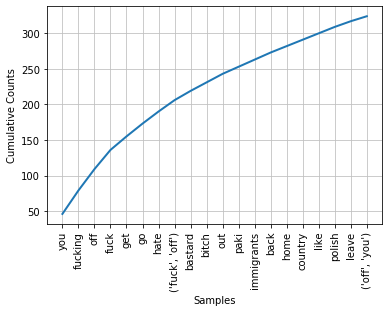

In [329]:
fd = nltk.FreqDist(vocab)
fd.plot(20, cumulative=True)
#fd.xlabel('Most common features')

In [330]:
fd.most_common(50)

[('you', 46),
 ('fucking', 33),
 ('off', 30),
 ('fuck', 27),
 ('get', 19),
 ('go', 18),
 ('hate', 17),
 (('fuck', 'off'), 16),
 ('bastard', 13),
 ('bitch', 12),
 ('out', 12),
 ('paki', 10),
 ('immigrants', 10),
 ('back', 10),
 ('home', 9),
 ('country', 9),
 ('like', 9),
 ('polish', 9),
 ('leave', 8),
 (('off', 'you'), 7),
 ('time', 7),
 ('niggers', 7),
 ('people', 6),
 ('black', 6),
 ('much', 6),
 ('terrorists', 6),
 ('cunt', 6),
 (('fuck', 'off', 'you'), 6),
 ('many', 6),
 ('faggot', 6),
 ('from', 6),
 ('never', 6),
 ('muslim', 5),
 ('nigger', 5),
 ('brexit', 5),
 ('let', 5),
 ('pakis', 5),
 ('road', 5),
 ('today', 4),
 ('cunts', 4),
 ('them', 4),
 ('shut', 4),
 ('one', 4),
 (('you', 'fucking'), 4),
 ('scum', 4),
 ('good', 4),
 ('right', 4),
 ('new', 4),
 ('really', 4),
 ('respect', 3)]

### Feature selection

Important for model running time and accuracy of the model: only give the classifier what matters

#### Removing rare and common features

#### Keeping the 50 most frequent words

Some features (tokens of ngrams) are only present in one or two tweet. We know that these are not going to be very useful to teach the model to recognise hate speech.  Let's only keep the top 50 most frequent features in the dataset

Features of interest here are the top 50 most frequent words. THIS IS NOT THE BEST WAY OF DOING IT! IT SHOULD REMOVE THE MOST FREQUENT WORDS!

In [331]:
import operator 

def get_word_features(wordlist, n):
    fd = nltk.FreqDist(wordlist)
    
    word_features = sorted(fd.items(), key=operator.itemgetter(1), reverse=True)[0:n] 
    word_features = [i[0] for i in word_features ]
    return word_features

# Only keep the top 50 most frequent words
chosen_features = get_word_features(vocab, 50)
print('Number of chosen features: {}/{}'.format(len(chosen_features), len(vocab)))

Number of chosen features: 50/3199


In [332]:
print(chosen_features[0:50])

['you', 'fucking', 'off', 'fuck', 'get', 'go', 'hate', ('fuck', 'off'), 'bastard', 'bitch', 'out', 'paki', 'immigrants', 'back', 'home', 'country', 'like', 'polish', 'leave', ('off', 'you'), 'time', 'niggers', 'people', 'black', 'much', 'terrorists', 'cunt', ('fuck', 'off', 'you'), 'many', 'faggot', 'from', 'never', 'muslim', 'nigger', 'brexit', 'let', 'pakis', 'road', 'today', 'cunts', 'them', 'shut', 'one', ('you', 'fucking'), 'scum', 'good', 'right', 'new', 'really', 'respect']


### Create input data for classifier

So far, we have chosen a list of features that we think are important for the model to learn the difference between hateful speech and non-hateful speech.

We now need to somehow tell the model:
- which features are typically present in hateful tweets and which are not,
- which features are typically present in non-hateful tweets and which are not.

Although pandas dataframes are handy to manipulate data, the classifier needs each tweet to be a dictionary of words mapped to True booleans. Something like this: 

[({'contains('go', 'home')' : TRUE, 'contains('good')' : FALSE}, 1), ({'contains('love')' : TRUE}, 0)]

0 and 1 are the labels:
- 1 means hateful
- 0 means non-hateful

Let's make this list of tuples!

In [333]:
def extract_features(document):
    document_words = set(document)
    feature_set = {}
    for feature in chosen_features:
        feature_set['contains({})'.format(feature)] = (feature in document_words)
    return feature_set

tweets = [tuple(x) for x in pre_processed_data.values]

feature_set = nltk.classify.apply_features(extract_features, tweets)


In [334]:
print('Number of tweets to feed in training_set: {}'.format(len(feature_set)))

Number of tweets to feed in training_set: 202


Lets' look at the first tweet. When scrolling all the way to the end, we see that this is a hateful tweet (label = 1). This will help the classifier know which features lead to being labelled hateful and which don't.

In [335]:
feature_set[0]

({"contains(('fuck', 'off'))": False,
  "contains(('fuck', 'off', 'you'))": False,
  "contains(('off', 'you'))": False,
  "contains(('you', 'fucking'))": False,
  'contains(back)': False,
  'contains(bastard)': False,
  'contains(bitch)': False,
  'contains(black)': False,
  'contains(brexit)': False,
  'contains(country)': False,
  'contains(cunt)': False,
  'contains(cunts)': False,
  'contains(faggot)': False,
  'contains(from)': False,
  'contains(fuck)': False,
  'contains(fucking)': False,
  'contains(get)': False,
  'contains(go)': False,
  'contains(good)': False,
  'contains(hate)': False,
  'contains(home)': False,
  'contains(immigrants)': False,
  'contains(leave)': False,
  'contains(let)': False,
  'contains(like)': False,
  'contains(many)': False,
  'contains(much)': False,
  'contains(muslim)': False,
  'contains(never)': False,
  'contains(new)': False,
  'contains(nigger)': False,
  'contains(niggers)': False,
  'contains(off)': False,
  'contains(one)': False,
  'co

The method is pretty simple. For each tweet, we are looping through our chosen_features and setting a boolean to True if the tweet contains that feature, False otherwise. 

This format is what the classifier needs as input.

We can now train the classifier with this training_data.

_________________________________________

## Part 3. Train the classifier

### Split data into train vs test datasets

We want to train the classifer and then test its classifying ability on a brand new dataset that it has never seen before. 

Generally, 80/20 percent is a fair split between training and testing set:
- training dataset (80% of the data)
- testing dataset (20% of the data)

Sklearn provides a function called train_test_split to do this easily.

In [336]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(feature_set, test_size=0.20, train_size=0.80)
print('Number of tweets in train data: {}'.format(len(train_data)))
print('Number of tweets in test data: {}'.format(len(test_data)))

Number of tweets in train data: 161
Number of tweets in test data: 41


In [337]:
train_data[0]

({"contains(('fuck', 'off'))": False,
  "contains(('fuck', 'off', 'you'))": False,
  "contains(('off', 'you'))": False,
  "contains(('you', 'fucking'))": False,
  'contains(back)': False,
  'contains(bastard)': False,
  'contains(bitch)': False,
  'contains(black)': False,
  'contains(brexit)': False,
  'contains(country)': False,
  'contains(cunt)': False,
  'contains(cunts)': False,
  'contains(faggot)': False,
  'contains(from)': False,
  'contains(fuck)': False,
  'contains(fucking)': False,
  'contains(get)': False,
  'contains(go)': False,
  'contains(good)': False,
  'contains(hate)': False,
  'contains(home)': False,
  'contains(immigrants)': False,
  'contains(leave)': False,
  'contains(let)': False,
  'contains(like)': False,
  'contains(many)': False,
  'contains(much)': False,
  'contains(muslim)': False,
  'contains(never)': False,
  'contains(new)': False,
  'contains(nigger)': False,
  'contains(niggers)': False,
  'contains(off)': False,
  'contains(one)': False,
  'co

### Train the model

There are many different types of model to use as a classifier. The most common one is called Naive Bayesion Classifier and that is the one we are going to use here.

In [338]:
# Naive Bayesian
classifier1 = nltk.NaiveBayesClassifier.train(training_set)
# SHOW FEATURES
classifier1.show_most_informative_features(10)


# Save the model into a pickle file
import pickle
f = open('classifier.pickle', 'wb')
pickle.dump(classifier1, f)
f.close()

# DecisionTree
#classifier2 = nltk.classify.DecisionTreeClassifier.train(training_set, entropy_cutoff=0,support_cutoff=0)


Most Informative Features
    contains(immigrants) = True                1 : 0      =      5.7 : 1.0
          contains(fuck) = True                1 : 0      =      5.0 : 1.0
    contains(terrorists) = True                1 : 0      =      4.3 : 1.0
       contains(fucking) = True                1 : 0      =      3.9 : 1.0
          contains(hate) = True                1 : 0      =      3.3 : 1.0
          contains(good) = True                0 : 1      =      2.3 : 1.0
          contains(time) = True                1 : 0      =      2.3 : 1.0
          contains(come) = True                0 : 1      =      2.3 : 1.0
         contains(black) = True                1 : 0      =      2.2 : 1.0
        contains(polish) = True                1 : 0      =      2.1 : 1.0


That's it! The model has been trained on the training_set. 

We can see which features the model considers important to decide between hateful speech and non-hateful speech.

- Column 3 shows the ratio of occurence of each informative feature in both labels (hate is 1 : non-hate is 0).
- Column 2 shows you the direction of the ratio (which label occurs more frequently). The label on the left is the label most associated with the corresponding feature.

For example, tweets containing the word 'immigrants' are 5.7 times more likely to be hateful than not.

Now let's test the accuracy of our model on the test_data that we set aside earlier. These are tweets that the model has never seen before. We'll ask the model to classify them and see how its outcome compares with the true label of the tweet.

### Test the classifier

In [339]:
accuracy =  nltk.classify.util.accuracy(classifier1, test_data)
accuracy

0.8536585365853658

## Part 5. Use the classifier to identify hateful speech

Ok let's try our classifier on a new tweet of your choice. First we need to preprocess the tweet (clean, tokenize and remove stopwords). Then we need to extract its features to look like the right input for the classifier.

In [340]:
testTweet = 'Hello world!'

In [341]:
# Prepare the tweet
def preprocessTweet(tweet):
    
    # clean the tweet
    tweet = cleanTweet(testTweet)
    
    # tokenize the cleaned tweet
    tokenised_tweet = nltk.word_tokenize(tweet)
    
    # remove stop words
    tokenised_tweet_stpwd = [item for item in tokenised_tweet if item not in stopWords]
    print('Preprocessed tweet: {}'.format(tokenised_tweet_stpwd))
    
    return tokenised_tweet_stpwd


preprocessed_tweet = preprocessTweet(testTweet)

Preprocessed tweet: ['hello', 'world']


In [342]:
# extract features
tweet_feature_set = extract_features(preprocessed_tweet) 
print(tweet_feature_set)

{'contains(you)': False, 'contains(fucking)': False, 'contains(off)': False, 'contains(fuck)': False, 'contains(get)': False, 'contains(go)': False, 'contains(hate)': False, "contains(('fuck', 'off'))": False, 'contains(bastard)': False, 'contains(bitch)': False, 'contains(out)': False, 'contains(paki)': False, 'contains(immigrants)': False, 'contains(back)': False, 'contains(home)': False, 'contains(country)': False, 'contains(like)': False, 'contains(polish)': False, 'contains(leave)': False, "contains(('off', 'you'))": False, 'contains(time)': False, 'contains(niggers)': False, 'contains(people)': False, 'contains(black)': False, 'contains(much)': False, 'contains(terrorists)': False, 'contains(cunt)': False, "contains(('fuck', 'off', 'you'))": False, 'contains(many)': False, 'contains(faggot)': False, 'contains(from)': False, 'contains(never)': False, 'contains(muslim)': False, 'contains(nigger)': False, 'contains(brexit)': False, 'contains(let)': False, 'contains(pakis)': False, '

In [343]:
print(classifier1.classify(tweet_feature_set))

0
